# Data Processing

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from scipy.io import wavfile
from scipy import signal
import os

In [2]:
#For Greek Database
def findMissing(path, start_letter, last_num):
    missing=[]
    directory = os.listdir(path)
    titles = []
    for num in range(1,last_num+1):
        for person in range(1,7):
            if num<10:
                titles.append(start_letter+"0"+str(num)+" ("+str(person)+").wav")
            else: titles.append(start_letter+str(num)+" ("+str(person)+").wav")
    for title in titles:
        if not title in directory:
            missing.append(title)
    return missing

print(findMissing("Anger", "a", 20))

['a04 (2).wav', 'a06 (1).wav', 'a10 (5).wav', 'a11 (1).wav', 'a11 (2).wav', 'a13 (3).wav', 'a20 (4).wav']


In [3]:
test_sample_rate, test_data = wavfile.read("Anger/a01 (1).wav")

In [4]:
f, t, Zxx = signal.stft(test_data, test_sample_rate, nperseg=int(test_sample_rate/5))

(0.0, 5000.0)

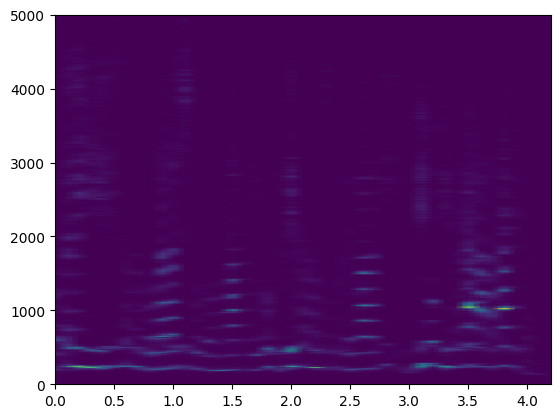

In [5]:
plt.pcolormesh(t, f, np.abs(Zxx), shading='gouraud', cmap="viridis")
plt.ylim([0,5000])

In [6]:
recording_data = {"freq":f, "all magnitudes":np.abs(Zxx)}

In [7]:
magnitude_average = np.mean(np.abs(Zxx), axis=1)
magnitude_median = [np.median(row) for row in np.abs(Zxx)]
magnitude_std = [row.std() for row in np.abs(Zxx)]
magnitude_min = np.quantile(np.abs(Zxx), 0.25, axis=1)
magnitude_max = np.quantile(np.abs(Zxx), 0.75, axis=1)

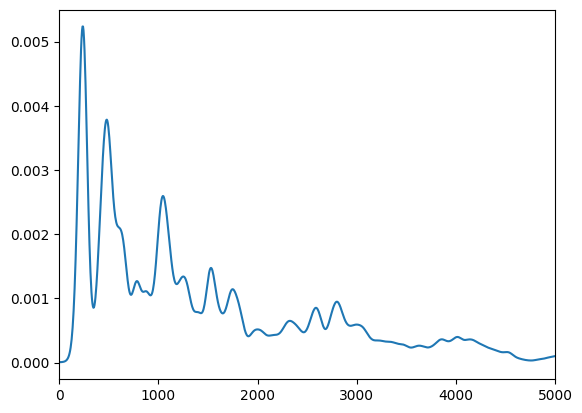

In [8]:
smoothed = scipy.ndimage.gaussian_filter1d(magnitude_average, sigma=7)
plt.xlim([0,5000])
plt.plot(f, smoothed)

In [9]:
average_peaks, properties = signal.find_peaks(smoothed, prominence=(0.0004, None))
print(len(average_peaks))
print(properties["prominences"].max())

5
0.00522900790656422


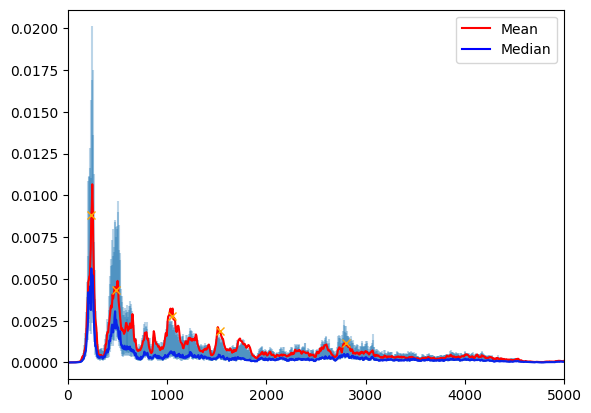

In [10]:
plt.errorbar(f, magnitude_median, yerr=[magnitude_min, magnitude_max], alpha=0.3)
plt.plot(f,magnitude_average, color="red", label="Mean")
plt.plot(f, magnitude_median, color="blue", label="Median")
plt.plot(f[average_peaks], magnitude_average[average_peaks], "x", color="orange")
plt.xlim([0,5000])
plt.legend()
plt.show()

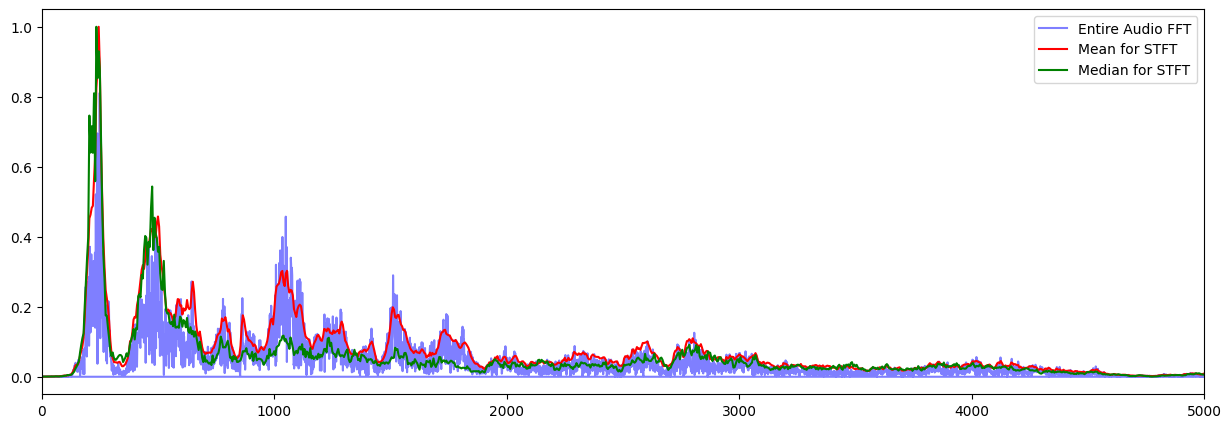

In [11]:
plt.figure(figsize=(15, 5))
entire_fft = scipy.fft.fft(test_data)
entire_freq = scipy.fft.fftfreq(len(test_data), d=1/test_sample_rate)
entire_fft = (entire_fft)/max(entire_fft)
plt.plot(entire_freq[::5], np.abs(entire_fft)[::5], color="blue", alpha=0.5, label="Entire Audio FFT")
plt.xlim([0,5000])
magnitude_average_normalized = (magnitude_average)/max(magnitude_average)
magnitude_median_normalized=(magnitude_median)/max(magnitude_median)
plt.plot(f, magnitude_average_normalized, color="red", label="Mean for STFT")
plt.plot(f,magnitude_median_normalized, color="green", label="Median for STFT")
plt.legend()
plt.show()

In [12]:
def AudioAnalysis(fileName):
    sample_rate, sample_data = wavfile.read(fileName)
    f, t, Zxx = signal.stft(sample_data, sample_rate, nperseg=int(sample_rate/5))
    magnitude_average = [row.mean() for row in np.abs(Zxx)]
    magnitude_median = [np.median(row) for row in np.abs(Zxx)]
    magnitude_average_normalized = (magnitude_average)/max(magnitude_average)
    magnitude_median_normalized=(magnitude_median)/max(magnitude_median)
    magnitude_std = [row.std() for row in np.abs(Zxx)]
    entire_fft = scipy.fft.fft(sample_data)
    entire_freq = scipy.fft.fftfreq(len(sample_data), d=1/sample_rate)
    entire_fft = (entire_fft)/max(entire_fft)
    return pd.DataFrame({""})

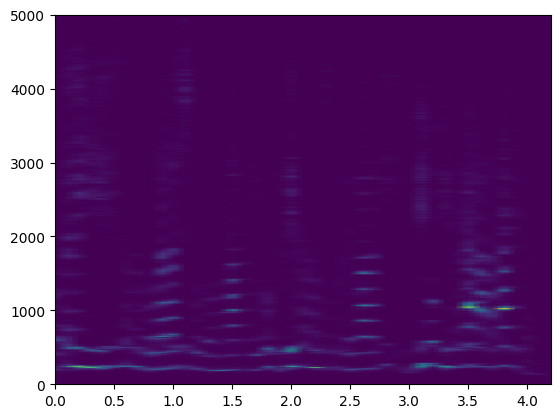

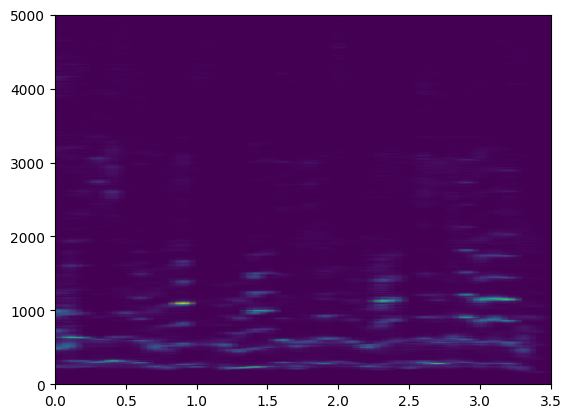

In [13]:
sample_rate, sample_data = wavfile.read("Anger/a01 (1).wav")
f, t, Zxx = signal.stft(sample_data, sample_rate, nperseg=int(sample_rate/5))
plt.pcolormesh(t, f, np.abs(Zxx), shading='gouraud', cmap="viridis")
plt.ylim([0,5000])
plt.show()

sample_rate, sample_data = wavfile.read("Anger/a01 (2).wav")
f, t, Zxx = signal.stft(sample_data, sample_rate, nperseg=int(sample_rate/5))
plt.pcolormesh(t, f, np.abs(Zxx), shading='gouraud', cmap="viridis")
plt.ylim([0,5000])
plt.show()

In [14]:
class Person:
    def __init__(self, number, emotions): #emotions: [("Anger", "a"), etc]
        self.files = {}
        for emote in emotions:
            missing = findMissing(emote[0], emote[1], 20)
            efiles = []
            for recording in range(1,21):
                file_name=emote[1]
                if recording <10:
                    file_name+="0"
                file_name+=str(recording)+" ("+str(number)+").wav"
                if not file_name in missing:
                    efiles.append(file_name)
            self.files[emote[0]] = efiles

def fileDataSummary(fileName, ratio=0.2):
    sample_rate, data = wavfile.read(fileName)
    f, t, Zxx = signal.stft(data, sample_rate, nperseg=int(test_sample_rate*ratio))
    magnitude_average = np.mean(np.abs(Zxx), axis=1)
    magnitude_median = [np.median(row) for row in np.abs(Zxx)]
    magnitude_min = np.quantile(np.abs(Zxx), 0.25, axis=1)
    magnitude_max = np.quantile(np.abs(Zxx), 0.75, axis=1)
    return {"freq_av":f, "time":t, "mean":magnitude_average, "median":magnitude_median, 
            "quantiles": [magnitude_min, magnitude_max]}


### Combining Data by Person

In [23]:
emotions = ["Anger", "Happiness", "Sadness", "Disgust", "Fear"]

def extract_person(filename):
    return filename.split("(")[-1].split(")")[0]

In [24]:
emotion_freqs = {}

for emotion in emotions:
    folder_path = os.path.join(emotion)
    if not os.path.exists(folder_path):
        print(f"Skipping {emotion}, folder not found.")
        continue

    emotion_freqs[emotion] = {}  # Store per-person data

    for filename in os.listdir(folder_path):
        if filename.endswith(".wav"):
            file_path = os.path.join(folder_path, filename)
            person_id = extract_person(filename)  # Extract person ID
            
            try:
                sample_rate, data = wavfile.read(file_path)
            except:
                print(f"Skipping {filename} due to read error.")
                continue  # Skip unreadable files

            # Compute STFT
            f, t, Zxx = signal.stft(data, sample_rate, nperseg=int(sample_rate/5))

            # Get the magnitude of the STFT
            magnitude = np.abs(Zxx)

            # Find the top 3 frequency peaks
            peak_freqs = f[np.argsort(magnitude.mean(axis=1))[-3:]]  # Select top 3 frequencies
            
            # Store data per person
            if person_id not in emotion_freqs[emotion]:
                emotion_freqs[emotion][person_id] = []
            emotion_freqs[emotion][person_id].append(peak_freqs)

print("✅ Finished grouping frequency data by emotion and person.")

/var/folders/wz/qrswb92s7jn3vl5zln9bllfw0000gn/T/ipykernel_45145/1071264547.py:17: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sample_rate, data = wavfile.read(file_path)


Skipping s05 (3).wav due to read error.
✅ Finished grouping frequency data by emotion and person.


In [28]:
emotion_stats = {}

for emotion, persons in emotion_freqs.items():
    if not persons:
        print(f"No data for {emotion}, skipping.")
        continue

    # Collect all frequency peaks for this emotion
    all_freqs = []
    
    for person_id, freq_list in persons.items():
        freq_array = np.array(freq_list)  # Convert person's recordings to an array
        avg_person_freqs = np.mean(freq_array, axis=0)  # Average across person's recordings
        all_freqs.append(avg_person_freqs)  # Store person's average

    # Convert all persons' averages into a single array
    all_freqs = np.array(all_freqs)

    # Compute mean and SEM for this emotion
    mean_freqs = np.round(np.mean(all_freqs, axis=0), 3)  # Round to 3 decimal places
    sem_freqs = np.round(scipy.stats.sem(all_freqs, axis=0), 3)  # Round to 3 decimal places

    # Store results
    emotion_stats[emotion] = {
        "mean": mean_freqs,
        "sem": sem_freqs
    }

In [29]:
df_stats = pd.DataFrame.from_dict(emotion_stats, orient='index')

print("✅ Finished calculating mean and standard error.")
df_stats

✅ Finished calculating mean and standard error.


,mean,sem
Anger,"[579.414, 567.056, 498.676]","[54.209, 70.302, 90.943]"
Happiness,"[437.377, 411.618, 384.803]","[21.001, 27.532, 44.467]"
Sadness,"[190.793, 174.8, 169.148]","[23.334, 32.865, 35.536]"
Disgust,"[437.724, 428.031, 416.454]","[28.212, 30.122, 32.513]"
Fear,"[319.549, 319.737, 310.218]","[21.64, 20.751, 21.575]"


### Comparing how the Top 3 Frequencies Change with Emotion

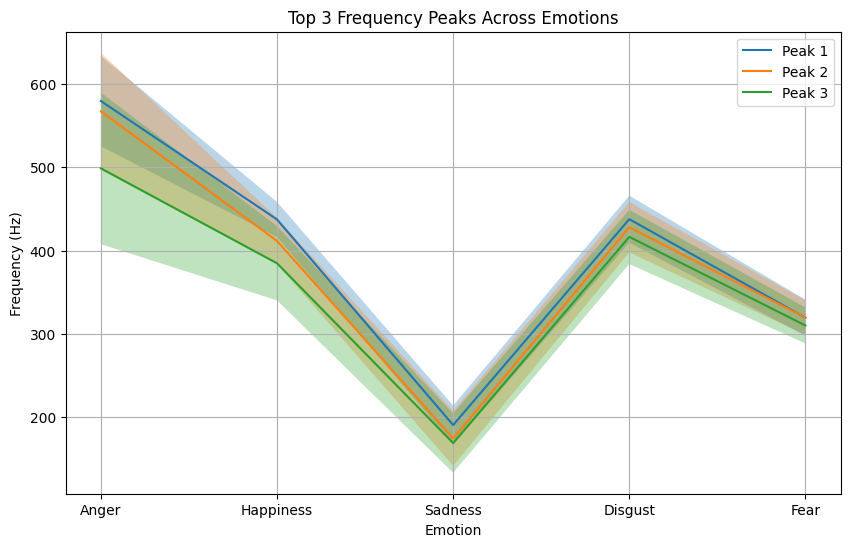

In [31]:
plt.figure(figsize=(10, 6))

for i in range(3):  # Top 3 peaks
    means = np.array([df_stats.loc[emotion]["mean"][i] for emotion in df_stats.index])
    errors = np.array([df_stats.loc[emotion]["sem"][i] for emotion in df_stats.index])

    # Use error bars as a shaded region (like your groupmate)
    plt.fill_between(df_stats.index, means - errors, means + errors, alpha=0.3)  # Shaded error range
    plt.plot(df_stats.index, means, label=f"Peak {i+1}")

plt.xlabel("Emotion")
plt.ylabel("Frequency (Hz)")
plt.title("Top 3 Frequency Peaks Across Emotions")
plt.legend()
plt.grid(True)
plt.show()